In [2]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand
import cerberus
import pyranges as pr
import upsetplot

p = os.path.dirname(os.getcwd())
sys.path.append(p)

from scripts.utils import *
from scripts.vcf_utils import *
from scripts.plotting import *

In [3]:
config = load_config()
od = '../'

def proc_cfg(entry, od):
    entry = entry.replace('../../', '')
    entry = od+entry
    return entry

In [4]:
df = load_meta()
df = df.loc[~df['sample'].str.contains('_')]
df['lab_sample'] = df['lab_number_sample'].astype(str)+'_'+\
                      df['lab_sampleid'].astype(str)+'_'+\
                      df['cell_line_id'].astype(str)
df = df[['cell_line_id', 'sample', 'hapmap_DNA_ID', 'lab_sample', 'population']].drop_duplicates()

temp_df = pd.read_csv('../snakemake/transcript_discovery_personal/cell_line_ids.txt', header=None, names=['cell_line_id'])

# make a 1000g cell line id col
df['cell_line_id_1000g'] = df.cell_line_id

inds = df.loc[~df.cell_line_id_1000g.isin(temp_df.cell_line_id.tolist())].index
df.loc[inds, 'cell_line_id_1000g'] = df.loc[inds, 'hapmap_DNA_ID']
len(df.index)

# limit to just those in 1000g
df = df.loc[df.cell_line_id_1000g.isin(temp_df.cell_line_id.tolist())]
assert len(df.index) == 30

# TODO bad sample that hasn't finished on espresso
# bad_samples = ['NA19328']
# df = df.loc[~df.cell_line_id_1000g.isin(bad_samples)]

hap = ['hap1', 'hap2']

meta_df = df.copy(deep=True)

## Canonicity df --> canonicity of all SJs in their respective refs.

In [5]:
file = proc_cfg(config['lr']['td_personal']['sqanti']['sj_summary'],od)
df = pd.read_csv(file)
df.drop('Unnamed: 0', axis=1, inplace=True)

cols = ['sj_id', 'splice_motif',
        'canonical', 'sqanti_genome', 'cell_line_id']

# dedupe hg38 guys
df.loc[df.sqanti_genome=='hg38', 'cell_line_id'] = ''
canon_df = df[cols]
print(len(canon_df.index))
canon_df = canon_df.drop_duplicates()
print(len(canon_df.index))

canon_df.head()

24934518
5817861


,sj_id,splice_motif,canonical,sqanti_genome,cell_line_id
0,KI270741.1_+_44470_47849,GTAG,canonical,hg38,
1,KI270741.1_+_48008_52058,GTAG,canonical,hg38,
2,KI270741.1_+_52137_130639,GTAG,canonical,hg38,
3,KI270741.1_+_44470_47948,GTAG,canonical,hg38,
4,GL000224.1_+_102592_105978,GTAG,canonical,hg38,


## Raw # SJs detected per sample per map haplotype

In [ ]:
file = proc_cfg(config['lr']['td_personal']['sqanti']['sj_summary'],od)
df = pd.read_csv(file)
df.drop('Unnamed: 0', axis=1, inplace=True)

# remove sqanti genome and drop dupes
# the sqanti genome / sqanti metrics SHOULD be irrelevant here
df = df.drop(['sqanti_genome', 'canonical', 'splice_motif'], axis=1)
print(len(df.index))
df = df.drop_duplicates()
print(len(df.index))

df.head()

# then make sure that there are no dupe. sj+sj nov+sample+map genome
temp = df.loc[df[['sj_id', 'junction_novelty',
                  'cell_line_id', 'map_genome', 'start_site_novelty',
                  'end_site_category']].duplicated(keep=False)]
assert len(temp.index) == 0
del temp

df.rename({'end_site_category': 'end_site_novelty'}, axis=1, inplace=True)

# transform to be t/f for each ic per genome
temp = pd.crosstab(index=[df.sj_id, df.junction_novelty,
                                 df.start_site_novelty,
                                 df.end_site_novelty, df.cell_line_id], 
                          columns=df.map_genome, 
                          values=df.map_genome, 
                          aggfunc=lambda x: True).fillna(False).reset_index()

24934518
8311506


In [ ]:
map_genomes = ['hg38', 'hap1', 'hap2']
temp = temp.set_index(map_genomes)

c_dict, order = get_novelty_colors()
init_plot_settings()
upset = upsetplot.UpSet(temp)
upset.plot()

In [ ]:
# just look at raw counts differences
temp = df[['sj_id', 'cell_line_id', 'map_genome']].groupby(['cell_line_id', 'map_genome']).nunique().reset_index().rename({'sj_id':'n_sj'}, axis=1)

# do paired wilcoxon tests for each haplotype
temp = temp.pivot(index='cell_line_id', columns='map_genome', values='n_sj').reset_index()

# Wilcoxon test: hap1 vs hg38. hyp is that hap1 > hg38
stat, pval = st.wilcoxon(temp['hap1'].tolist(), temp['hg38'].tolist(), alternative='greater')
print(f"hap1 vs hg38: Wilcoxon stat = {stat}, p-value = {pval:.3f}")


# Wilcoxon test: hap2 vs hg38. hyp is that hap2 > hg38
stat, pval = st.wilcoxon(temp['hap2'].tolist(), temp['hg38'].tolist(), alternative='greater')
print(f"hap2 vs hg38: Wilcoxon stat = {stat}, p-value = {pval:.3f}")

In [ ]:
temp['hap1_diff'] = temp['hap1']-temp['hg38']
temp['hap2_diff'] = temp['hap2']-temp['hg38']
temp['hap1_perc_diff'] = (temp['hap1_diff']/temp['hg38'])*100
temp['hap2_perc_diff'] = (temp['hap2_diff']/temp['hg38'])*100

In [ ]:
import statistics
thing = temp.hap1_diff.tolist()+temp.hap2_diff.tolist()
statistics.median(thing)

In [ ]:
import statistics
thing = temp.hap1_perc_diff.tolist()+temp.hap2_perc_diff.tolist()
statistics.median(thing)

In [ ]:
print(len(temp.loc[temp.hap1_diff<0]))
print(len(temp.loc[temp.hap2_diff<0]))

In [ ]:
# visualization
init_plot_settings(aspect='square')
temp2 = temp.melt(id_vars=['cell_line_id'], 
                      value_vars=['hap1', 'hap2', 'hg38'], 
                      var_name='map_genome', 
                      value_name='n_sj')
temp2 = temp2.merge(meta_df[['cell_line_id_1000g', 'population']],
                    how='left',
                    left_on='cell_line_id',
                    right_on='cell_line_id_1000g')

# Plot
plt.figure(figsize=(8, 5))
sns.lineplot(data=temp2, x='map_genome', y='n_sj', hue='cell_line_id', marker='o', palette="tab10",
             linewidth=2, alpha=0.6, legend=False)

plt.ylabel("# SJs")
plt.xlabel("Mapping+transcript discovery genome")
plt.grid(True)
plt.show()

## Are there any differences that are bigger for different populations?

In [ ]:
temp = temp.merge(meta_df[['cell_line_id_1000g', 'population']],
                    how='left',
                    left_on='cell_line_id',
                    right_on='cell_line_id_1000g')

In [ ]:
init_plot_settings(aspect='rectangle')
c_dict, order = get_population_colors(cats=temp.population.unique().tolist())
ax = sns.boxplot(temp,
            x='population',
            y='hap1_perc_diff',
            palette=c_dict,
            order=order, 
            saturation=0.75,
            showfliers=False)
sns.stripplot(x='population', y='hap1_perc_diff', data=temp, jitter=True,
              palette=c_dict,
              order=order,
              size=10,
              edgecolor='k')
_ = ax.set(xlabel='', ylabel='% increase in # SJs\n(haplotype 1)')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [ ]:
init_plot_settings(aspect='rectangle')
c_dict, order = get_population_colors(cats=temp.population.unique().tolist())
ax = sns.boxplot(temp,
            x='population',
            y='hap2_perc_diff',
            palette=c_dict,
            order=order, 
            saturation=0.75,
            showfliers=False)
sns.stripplot(x='population', y='hap2_perc_diff', data=temp, jitter=True,
              palette=c_dict,
              order=order,
              size=10,
              edgecolor='k')
_ = ax.set(xlabel='', ylabel='% increase in # SJs\n(haplotype 2)')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [ ]:
# put the bois together (melt)
temp2 = temp[['hap1_perc_diff', 'hap2_perc_diff', 'population', 'cell_line_id']].melt(id_vars=['population', 'cell_line_id'])
init_plot_settings(aspect='rectangle')
c_dict, order = get_population_colors(cats=temp.population.unique().tolist())
ax = sns.boxplot(temp2,
            x='population',
            y='value',
            palette=c_dict,
            order=order, 
            saturation=0.75,
            showfliers=False)
sns.stripplot(x='population', y='value', data=temp2, jitter=True,
              palette=c_dict,
              order=order,
              size=10,
              edgecolor='k')
_ = ax.set(xlabel='', ylabel='% increase in # SJs\nin synthetic haplotype')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [ ]:
# test -- Mann-Whitney U for each pop. pair with hypothesis greater
import itertools

stat_df = pd.DataFrame()
for p1, p2 in list(itertools.permutations(temp2.population.unique(), 2)):
    x = temp2.loc[temp2.population==p1,'value'].tolist() # hyp. --> greater
    y = temp2.loc[temp2.population==p2,'value'].tolist()
    
    stat, pval = st.mannwhitneyu(x, y, alternative='greater')
    temp3 = pd.DataFrame(data=[[p1, p2, stat, pval]], 
                         columns=['pop1', 'pop2', 'stat', 'pval'])
    stat_df = pd.concat([stat_df, temp3], axis=0)
    del temp3

In [ ]:
# fdr correction
stat_df['adj_pval'] = st.false_discovery_control(stat_df.pval.tolist(),
                                                 method='bh')

In [ ]:
# add sig. annotation
# * <= 0.05
# ** <= 0.01
# *** <= 0.001
stat_df['sig_annot'] = ''
# stat_df.loc[stat_df.pval <= 0.05, 'sig_annot'] = '*'
# stat_df.loc[stat_df.pval <= 0.01, 'sig_annot'] = '**'
# stat_df.loc[stat_df.pval <= 0.001, 'sig_annot'] = '***'
stat_df.loc[stat_df.adj_pval <= 0.05, 'sig_annot'] = '*'
stat_df.loc[stat_df.adj_pval <= 0.01, 'sig_annot'] = '**'
stat_df.loc[stat_df.adj_pval <= 0.001, 'sig_annot'] = '***'

In [ ]:
# pivot x2 to get a stat and annot df to plot
stat_df1 = stat_df.pivot(index='pop1', columns='pop2', values='stat')
annot_df = stat_df.pivot(index='pop1', columns='pop2', values='sig_annot')

In [ ]:
ax = sns.heatmap(stat_df1, cmap='Purples',
            annot=annot_df,
            fmt='',
            cbar_kws={'label': 'Mann-Whitney U\ntest statistic'})

# labels need them
ax.set(xlabel='Population 2',
       ylabel='Popluation 1',
       title='Population differences in % increase\nof detected SJs')

## What do gains look like in terms of different SJ novelty categories?

In [183]:
file = proc_cfg(config['lr']['td_personal']['sqanti']['sj_summary'],od)
df = pd.read_csv(file)
df.drop('Unnamed: 0', axis=1, inplace=True)

# remove sqanti genome and drop dupes
# the sqanti genome / sqanti metrics SHOULD be irrelevant here
df = df.drop(['sqanti_genome', 'canonical', 'splice_motif'], axis=1)
print(len(df.index))
df = df.drop_duplicates()
print(len(df.index))

df.head()

# then make sure that there are no dupe. ic+structural cat+sample+map genome
temp = df.loc[df[['sj_id', 'junction_novelty',
                  'cell_line_id', 'map_genome', 'start_site_novelty',
                  'end_site_category']].duplicated(keep=False)]
assert len(temp.index) == 0
del temp

df.rename({'end_site_category': 'end_site_novelty'}, axis=1, inplace=True)

# transform to be t/f for each ic per genome
temp = pd.crosstab(index=[df.sj_id, df.junction_novelty,
                                 df.start_site_novelty,
                                 df.end_site_novelty, df.cell_line_id], 
                          columns=df.map_genome, 
                          values=df.map_genome, 
                          aggfunc=lambda x: True).fillna(False).reset_index()

temp['sj_novelty'] = 'Novel SJ: 1 Novel SS'
temp.loc[(temp.junction_novelty=='novel')&\
         (temp.start_site_novelty=='known')&\
         (temp.end_site_novelty=='known'), 'sj_novelty'] = 'Novel SJ: Known SS'
temp.loc[(temp.junction_novelty=='known'), 'sj_novelty'] = 'Known'
temp.loc[(temp.junction_novelty=='novel')&\
         (temp.start_site_novelty=='novel')&\
         (temp.end_site_novelty=='novel'), 'sj_novelty'] = 'Novel SJ: 2 Novel SS'

24934518
8311506


In [184]:
def get_sj_novelty_colors(cats=None):
    palette = {'Known': "#a23a5f",
               'Novel SJ: 1 Novel SS': "#d7aebc", 
               'Novel SJ: 2 Novel SS': "#e9ced7", 
               'Novel SJ: Known SS': "#c27d97"}
    order = ['Known', 'Novel SJ: Known SS',
             'Novel SJ: 1 Novel SS',
             'Novel SJ: 2 Novel SS']

    palette, order = rm_color_cats(palette, order, cats)
    return palette, order

[Text(0, 0, 'Known'),
 Text(1, 0, 'Novel SJ: Known SS'),
 Text(2, 0, 'Novel SJ: 1 Novel SS'),
 Text(3, 0, 'Novel SJ: 2 Novel SS')]

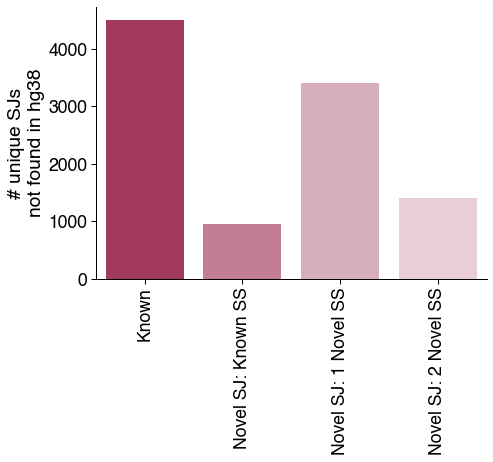

In [185]:
# get just the sjs that are not detected (per sample) in hg38
temp2 = temp.loc[temp.hg38==False]
c_dict, order = get_sj_novelty_colors()
temp2 = temp2[['sj_id', 'sj_novelty']].groupby('sj_novelty').nunique().reset_index().rename({'sj_id':'n_sj'}, axis=1)
ax = sns.barplot(temp2, x='sj_novelty',
                 y='n_sj',
                 palette=c_dict,
                 order=order,
                 saturation=1)
ax.set(ylabel='# unique SJs\nnot found in hg38', xlabel='')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

In [186]:
map_genomes = ['hg38', 'hap1', 'hap2']
temp = temp.set_index(map_genomes)

In [187]:
# merge in canonicity (hg38) to check if this is correct
temp.reset_index(inplace=True)
hg38_canon_df = canon_df.loc[canon_df.sqanti_genome=='hg38']
assert len(hg38_canon_df.loc[hg38_canon_df.sj_id.duplicated()]) == 0
temp = temp.merge(hg38_canon_df,
                  how='left',
                  on='sj_id')

In [188]:
# check if there are any novel NC splice junctions in hg38 when
# mapping to hg38
assert len(temp.loc[(temp.sj_novelty!='Known')&
         (temp.canonical=='non_canonical')&
         (temp.hg38==True)&
         (temp.sqanti_genome=='hg38')]) == 0

In [189]:
temp = temp.set_index(map_genomes)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


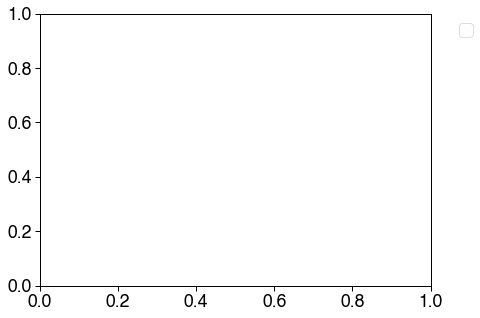

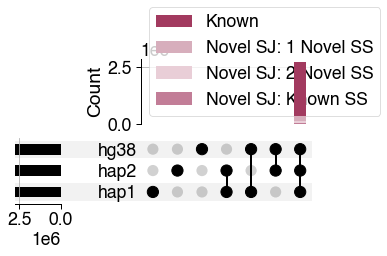

In [190]:
c_dict, order = get_sj_novelty_colors()
upset = upsetplot.UpSet(temp, intersection_plot_elements=0)  # disable the default bar chart
upset.add_stacked_bars(
    by="sj_novelty", title="Count",
    colors=c_dict)
# upset.add_catplot(
#     kind='box',
#     hue='canonical_hg38',
#     value='perc_canonicity')
# ax = plt.gca()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
upset.plot()
plt.savefig('td_personal_hg38_sj_novelty_barplot_canonicity_boxplot.pdf', dpi=500)

In [191]:
# check if there are any novel NC splice junctions in hg38 when
# mapping to hg38
temp = temp.reset_index()
assert len(temp.loc[(temp.sj_novelty!='Known')&
         (temp.canonical=='non_canonical')&
         (temp.hg38==True)&
         (temp.sqanti_genome=='hg38')]) == 0

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


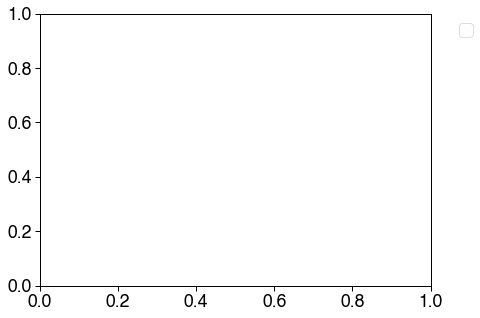

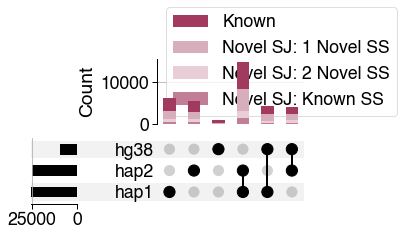

In [192]:
c_dict, order = get_sj_novelty_colors()
temp2 = temp.loc[temp[map_genomes].sum(axis=1)<3]
temp2 = temp2.set_index(map_genomes)
upset = upsetplot.UpSet(temp2, intersection_plot_elements=0)  # disable the default bar chart
upset.add_stacked_bars(
    by="sj_novelty", title="Count",
    colors=c_dict)
# upset.add_catplot(
#     kind='box',
#     hue='canonical_hg38',
#     value='perc_canonicity')
# ax = plt.gca()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
upset.plot()
plt.savefig('td_personal_hg38_sj_novelty_barplot_canonicity_boxplot.pdf', dpi=500)

In [193]:
# check if there are any novel NC splice junctions in hg38 when
# mapping to hg38
temp2 = temp2.reset_index()
assert len(temp2.loc[(temp2.sj_novelty!='Known')&
         (temp2.canonical=='non_canonical')&
         (temp2.hg38==True)&
         (temp2.sqanti_genome=='hg38')]) == 0

## Look at % Novel NC SJs based on different sqanti genomes

In [6]:
file = proc_cfg(config['lr']['td_personal']['sqanti']['sj_summary'],od)
df = pd.read_csv(file)
df.drop('Unnamed: 0', axis=1, inplace=True)

# remove sqanti genome and drop dupes
# the sqanti genome / sqanti metrics SHOULD be irrelevant here
df = df.drop(['sqanti_genome', 'canonical', 'splice_motif'], axis=1)
print(len(df.index))
df = df.drop_duplicates()
print(len(df.index))


# then make sure that there are no dupe. ic+structural cat+sample+map genome
temp = df.loc[df[['sj_id', 'junction_novelty',
                  'cell_line_id', 'map_genome', 'start_site_novelty',
                  'end_site_category']].duplicated(keep=False)]
assert len(temp.index) == 0
del temp

df.rename({'end_site_category': 'end_site_novelty'}, axis=1, inplace=True)

# transform to be t/f for each ic per genome
df = pd.crosstab(index=[df.sj_id, df.junction_novelty,
                                 df.start_site_novelty,
                                 df.end_site_novelty, df.cell_line_id], 
                          columns=df.map_genome, 
                          values=df.map_genome, 
                          aggfunc=lambda x: True).fillna(False).reset_index()

df['sj_novelty'] = 'Novel SJ: 1 Novel SS'
df.loc[(df.junction_novelty=='novel')&\
         (df.start_site_novelty=='known')&\
         (df.end_site_novelty=='known'), 'sj_novelty'] = 'Novel SJ: Known SS'
df.loc[(df.junction_novelty=='known'), 'sj_novelty'] = 'Known'
df.loc[(df.junction_novelty=='novel')&\
         (df.start_site_novelty=='novel')&\
         (df.end_site_novelty=='novel'), 'sj_novelty'] = 'Novel SJ: 2 Novel SS'

24934518
8311506


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped
1 extra bytes in post.stringData array
'created' timestamp seems very low; rega

<Figure size 1296x864 with 0 Axes>

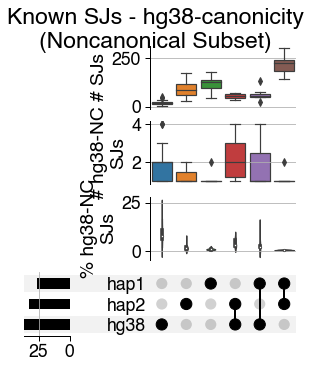

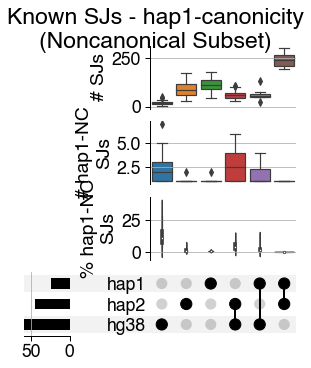

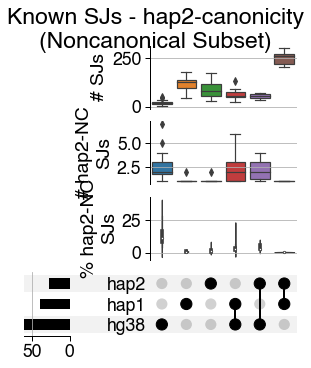

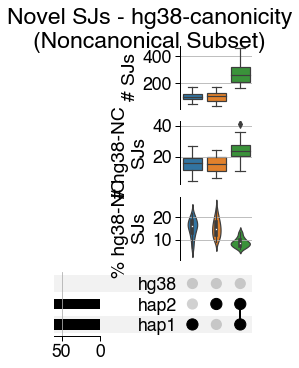

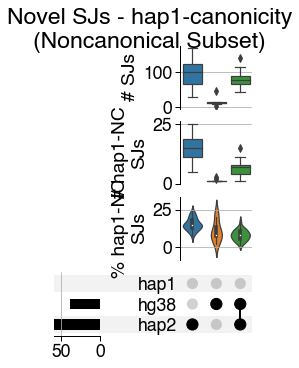

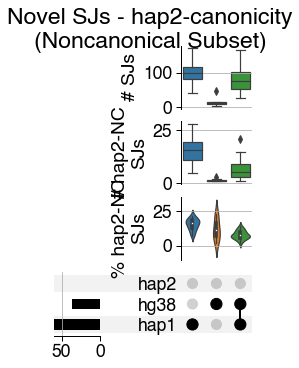

In [19]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import upsetplot
from PyPDF2 import PdfWriter, PdfReader
import os
from matplotlib.gridspec import GridSpec
init_plot_settings()

# Directory to store individual plots
os.makedirs("temp_plots", exist_ok=True)

# Define outer (rows) and inner (columns) loops
novelty_levels = df.junction_novelty.unique()  # ['known', 'novel']
map_genomes = ['hg38', 'hap1', 'hap2']  # Columns

my_df = pd.DataFrame()

# Loop for each figure type
# for figure_type in ['full_upset', 'subset_upset', 'noncanonical_upset', 'noncanonical_subset']:
for figure_type in ['noncanonical_subset']:

    # Initialize figure and GridSpec
    fig = plt.figure(figsize=(18, 12))
    grid = GridSpec(2, 3, figure=fig)  # 2 rows for novelty, 3 columns for sqanti genomes
    fig.suptitle(f"Grid Plot for {figure_type.replace('_', ' ').title()}", fontsize=18)

    # Iterate through novelty (rows) and sqanti genomes (columns)
    for row_idx, nov in enumerate(novelty_levels):  # Rows: known, novel
        for col_idx, sg in enumerate(map_genomes):  # Columns: hg38, hap1, hap2
            # Prepare your data
            temp = df.loc[(df.junction_novelty == nov)]
            
            # for haps 1/2 make sure there's sample concordance
            merge_cols = ['sj_id']
            merge_canon_df = canon_df.loc[canon_df.sqanti_genome==sg]
            if sg != 'hg38':
                merge_cols += ['cell_line_id']
            else:
                merge_canon_df.drop('cell_line_id', axis=1, inplace=True)
                
            temp = temp.merge(
                merge_canon_df,
                how='left',
                on=merge_cols
            )
            assert len(temp.index) == len(temp[['sj_id', 'cell_line_id']].drop_duplicates())

            # get # uniq novel sjs per map+td, cell line, and C vs. NC
            gb_cols = ['hg38', 'hap1', 'hap2', 'cell_line_id', 'canonical']
            keep_cols = gb_cols + ['sj_id']
            temp_sjs = temp[keep_cols].groupby(gb_cols).nunique().reset_index().rename({'sj_id':'n_sj'}, axis=1)

            # get # uniq novel sjs per map+td, cell line
            gb_cols = ['hg38', 'hap1', 'hap2', 'cell_line_id']
            keep_cols = gb_cols + ['sj_id']
            temp_sjs2 = temp[keep_cols].groupby(gb_cols).nunique().reset_index().rename({'sj_id':'n_total_sj'}, axis=1)
            temp_sjs = temp_sjs.merge(temp_sjs2, 
                              how='left', 
                              on=map_genomes+['cell_line_id'])
            temp_sjs['perc'] = (temp_sjs['n_sj']/temp_sjs['n_total_sj'])*100

            rename = {'perc': '% SJs', 'n_total_sj': '# SJs'}
            temp_sjs.rename(rename, axis=1, inplace=True)
            canon_map = {'canonical': True, 'non_canonical': False}
            temp_sjs['canonical'] = temp_sjs.canonical.map(canon_map)
            temp_sjs.set_index(map_genomes, inplace=True)


            # # Create an UpSet plot
            fig = plt.figure(figsize=(8, 8))
            
            # Apply the specific figure type logic
            if figure_type == 'full_upset':
                upset = upsetplot.UpSet(temp_sjs, intersection_plot_elements=0)
                upset.add_catplot(kind='violin', hue='canonical', value='% SJs', legend=False)
                upset.add_catplot(kind='box', value='# SJs')
                
            elif figure_type == 'subset_upset':
                temp2 = temp_sjs.reset_index()
                temp2 = temp2.loc[temp2[map_genomes].sum(axis=1) < 3]
                temp2.set_index(map_genomes, inplace=True)
                
                upset = upsetplot.UpSet(temp2, intersection_plot_elements=0)
                upset.add_catplot(kind='violin', hue='canonical', value='% SJs', legend=False)
                upset.add_catplot(kind='box', value='# SJs')
                
            elif figure_type == 'noncanonical_upset':
                temp2 = temp_sjs.loc[temp_sjs.canonical == False]
                nc_perc_col = f'% {sg}-NC\nSJs'
                nc_num_col = f'# {sg}-NC\nSJs' 
                temp2.rename({'% SJs': nc_perc_col,
                              'n_sj': nc_num_col}, axis=1, inplace=True)
                
                upset = upsetplot.UpSet(temp2, intersection_plot_elements=0)
                upset.add_catplot(kind='violin', value=nc_perc_col)
                upset.add_catplot(kind='box', value=nc_num_col)
                upset.add_catplot(kind='box', value='# SJs')
                
            elif figure_type == 'noncanonical_subset':
                temp2 = temp_sjs.loc[temp_sjs.canonical == False].reset_index()
                temp2 = temp2.loc[temp2[map_genomes].sum(axis=1) < 3]
                nc_perc_col = f'% {sg}-NC\nSJs'
                nc_num_col = f'# {sg}-NC\nSJs' 
                temp2.rename({'% SJs': nc_perc_col,
                              'n_sj': nc_num_col}, axis=1, inplace=True)
                temp2.set_index(map_genomes, inplace=True)
                
                upset = upsetplot.UpSet(temp2, intersection_plot_elements=0)
                upset.add_catplot(kind='violin', value=nc_perc_col)
                upset.add_catplot(kind='box', value=nc_num_col)
                upset.add_catplot(kind='box', value='# SJs')
                
                # for this one too, also add to df
                # temp2['sqanti_genome'] = sg
                my_df = pd.concat([my_df, temp2], axis=0)

            upset.plot()
                
            plt.suptitle(f"{nov.capitalize()} SJs - {sg}-canonicity\n({figure_type.replace('_', ' ').title()})")
            plt.savefig(f"temp_plots/{figure_type}_{nov}_{sg}.pdf", bbox_inches='tight', format='pdf')
            plt.close(fig)

In [18]:
# try plotting these differently
my_df.head()

cell_line_id  canonical  n_sj  # SJs  % hg38-NC\nSJs  \
hg38  hap1  hap2                                                        
False False True      HG00621      False     1     57        1.754386   
            True      HG01928      False     1     90        1.111111   
            True      HG01975      False     2     75        2.666667   
            True      HG02261      False     2    109        1.834862   
            True      HG02293      False     2     31        6.451613   

                 sqanti_genome  % hap1-NC\nSJs  % hap2-NC\nSJs  
hg38  hap1  hap2                                                
False False True          hg38             NaN             NaN  
            True          hg38             NaN             NaN  
            True          hg38             NaN             NaN  
            True          hg38             NaN             NaN  
            True          hg38             NaN             NaN

## Now check the % of novel SJs that are hg38-NC per map+td intersection and plot

In [180]:
# get only novel
assert len(temp2.sj_id.unique()) == len(temp2[['sj_id', 'sj_novelty']].drop_duplicates())
assert len(temp2.sqanti_genome.unique()) == 1
temp2 = temp2.loc[temp2.sj_novelty != 'Known']

AttributeError: 'DataFrame' object has no attribute 'sj_id'

In [181]:
# get # uniq novel sjs per map+td, cell line, and C vs. NC
gb_cols = ['hg38', 'hap1', 'hap2', 'cell_line_id', 'canonical']
keep_cols = gb_cols + ['sj_id']
temp3 = temp2[keep_cols].groupby(gb_cols).nunique().reset_index().rename({'sj_id':'n_sj'}, axis=1)

KeyError: "['hg38', 'hap1', 'hap2', 'canonical', 'sj_id'] not in index"

In [182]:
# get total number of novel sjs per map_td, cell line
gb_cols = ['hg38', 'hap1', 'hap2', 'cell_line_id']
keep_cols = gb_cols + ['sj_id']
temp4 = temp2[keep_cols].groupby(gb_cols).nunique().reset_index().rename({'sj_id':'# SJs'}, axis=1)
temp5 = temp3.merge(temp4, 
                    how='left',
                    on=['cell_line_id', 'hap1', 'hap2', 'hg38'])

KeyError: "['hg38', 'hap1', 'hap2', 'sj_id'] not in index"

In [126]:
# perc
temp5['% NC SJs'] = (temp5['n_sj']/temp5['# SJs'])*100

In [127]:
# only NC
temp5 = temp5.loc[temp5.canonical=='non_canonical']
temp5[map_genomes].drop_duplicates()

,hg38,hap1,hap2
1,False,False,True
61,False,True,False
121,False,True,True


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


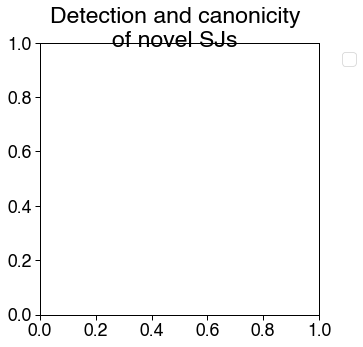

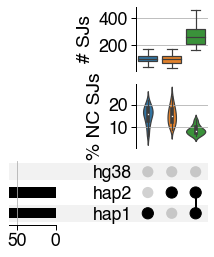

In [107]:
init_plot_settings()
upset = upsetplot.UpSet(temp5, intersection_plot_elements=0)  # disable the default bar chart
upset.add_catplot(
    kind='violin',
    value='% NC SJs')
upset.add_catplot(
    kind='box',
    value='# SJs')
ax = plt.gca()
plt.suptitle('Detection and canonicity\nof novel SJs')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
upset.plot()
plt.savefig('td_personal_novel_sj_det_canon_violin_box_upset.pdf', dpi=500)

In [112]:
temp6 = temp5.reset_index()
print(temp6[['hg38', 'hap1', 'hap2']].drop_duplicates())
del temp6

     hg38   hap1   hap2
0   False  False   True
30  False   True  False
60  False   True   True
